# Artificial Intelligence Nanodegree

## Add-ons : check configuration

In [1]:
# Add-on : Check GPU
from tensorflow.python.client import device_lib
from tensorflow import test

if test.is_gpu_available:
    devices=device_lib.list_local_devices()
    gpu=[(x.physical_device_desc) for x in devices if x.device_type == 'GPU']
    print("GPU :", gpu)

# Add-on : Check framework versions being used 
import tensorflow as tf
import keras as K
import sys
print("Python", sys.version)
print("Tensorflow version", tf.__version__)
print("Keras version", K.__version__)

GPU : ['device: 0, name: TITAN Xp COLLECTORS EDITION, pci bus id: 0000:02:00.0']


Using TensorFlow backend.
/opt/DataScience/lib/python3.5/site-packages/h5py/__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Python 3.5.5 |Anaconda, Inc.| (default, May 13 2018, 21:12:35) 
[GCC 7.2.0]
Tensorflow version 1.1.0
Keras version 2.0.5




## Voice User Interfaces

## Project: Speech Recognition with Neural Networks

---

In this notebook, some template code has already been provided for you, and you will need to implement additional functionality to successfully complete this project. You will not need to modify the included code beyond what is requested. Sections that begin with **'(IMPLEMENTATION)'** in the header indicate that the following blocks of code will require additional functionality which you must provide. Please be sure to read the instructions carefully! 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the Jupyter Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question X'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut.  Markdown cells can be edited by double-clicking the cell to enter edit mode.

The rubric contains _optional_ "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. If you decide to pursue the "Stand Out Suggestions", you should include the code in this Jupyter notebook.

---

## Introduction  

In this notebook, you will build a deep neural network that functions as part of an end-to-end automatic speech recognition (ASR) pipeline!  Your completed pipeline will accept raw audio as input and return a predicted transcription of the spoken language.  The full pipeline is summarized in the figure below.

<img src="images/pipeline.png">

- **STEP 1** is a pre-processing step that converts raw audio to one of two feature representations that are commonly used for ASR. 
- **STEP 2** is an acoustic model which accepts audio features as input and returns a probability distribution over all potential transcriptions.  After learning about the basic types of neural networks that are often used for acoustic modeling, you will engage in your own investigations, to design your own acoustic model!
- **STEP 3** in the pipeline takes the output from the acoustic model and returns a predicted transcription.  

Feel free to use the links below to navigate the notebook:
- [The Data](#thedata)
- [**STEP 1**](#step1): Acoustic Features for Speech Recognition
- [**STEP 2**](#step2): Deep Neural Networks for Acoustic Modeling
    - [Model 0](#model0): RNN
    - [Model 1](#model1): RNN + TimeDistributed Dense
    - [Model 2](#model2): CNN + RNN + TimeDistributed Dense
    - [Model 3](#model3): Deeper RNN + TimeDistributed Dense
    - [Model 4](#model4): Bidirectional RNN + TimeDistributed Dense
    - [Models 5+](#model5)
    - [Compare the Models](#compare)
    - [Final Model](#final)
- [**STEP 3**](#step3): Obtain Predictions

<a id='thedata'></a>
## The Data

We begin by investigating the dataset that will be used to train and evaluate your pipeline.  [LibriSpeech](http://www.danielpovey.com/files/2015_icassp_librispeech.pdf) is a large corpus of English-read speech, designed for training and evaluating models for ASR.  The dataset contains 1000 hours of speech derived from audiobooks.  We will work with a small subset in this project, since larger-scale data would take a long while to train.  However, after completing this project, if you are interested in exploring further, you are encouraged to work with more of the data that is provided [online](http://www.openslr.org/12/).

In the code cells below, you will use the `vis_train_features` module to visualize a training example.  The supplied argument `index=0` tells the module to extract the first example in the training set.  (You are welcome to change `index=0` to point to a different training example, if you like, but please **DO NOT** amend any other code in the cell.)  The returned variables are:
- `vis_text` - transcribed text (label) for the training example.
- `vis_raw_audio` - raw audio waveform for the training example.
- `vis_mfcc_feature` - mel-frequency cepstral coefficients (MFCCs) for the training example.
- `vis_spectrogram_feature` - spectrogram for the training example. 
- `vis_audio_path` - the file path to the training example.

In [1]:
from data_generator import vis_train_features

# extract label and audio features for a single training example
vis_text, vis_raw_audio, vis_mfcc_feature, vis_spectrogram_feature, vis_audio_path = vis_train_features()

There are 2136 total training examples.


The following code cell visualizes the audio waveform for your chosen example, along with the corresponding transcript.  You also have the option to play the audio in the notebook!

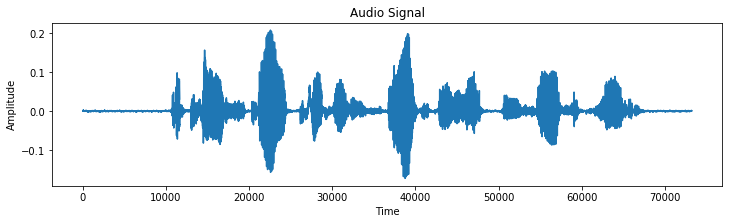

**Shape of Audio Signal** : (73206,)

**Transcript** : the two stray kittens gradually make themselves at home

In [2]:
from IPython.display import Markdown, display
from data_generator import vis_train_features, plot_raw_audio
from IPython.display import Audio
%matplotlib inline

# plot audio signal
plot_raw_audio(vis_raw_audio)
# print length of audio signal
display(Markdown('**Shape of Audio Signal** : ' + str(vis_raw_audio.shape)))
# print transcript corresponding to audio clip
display(Markdown('**Transcript** : ' + str(vis_text)))
# play the audio file
Audio(vis_audio_path)

<a id='step1'></a>
## STEP 1: Acoustic Features for Speech Recognition

For this project, you won't use the raw audio waveform as input to your model.  Instead, we provide code that first performs a pre-processing step to convert the raw audio to a feature representation that has historically proven successful for ASR models.  Your acoustic model will accept the feature representation as input.

In this project, you will explore two possible feature representations.  _After completing the project_, if you'd like to read more about deep learning architectures that can accept raw audio input, you are encouraged to explore this [research paper](https://pdfs.semanticscholar.org/a566/cd4a8623d661a4931814d9dffc72ecbf63c4.pdf).

### Spectrograms

The first option for an audio feature representation is the [spectrogram](https://www.youtube.com/watch?v=_FatxGN3vAM).  In order to complete this project, you will **not** need to dig deeply into the details of how a spectrogram is calculated; but, if you are curious, the code for calculating the spectrogram was borrowed from [this repository](https://github.com/baidu-research/ba-dls-deepspeech).  The implementation appears in the `utils.py` file in your repository.

The code that we give you returns the spectrogram as a 2D tensor, where the first (_vertical_) dimension indexes time, and the second (_horizontal_) dimension indexes frequency.  To speed the convergence of your algorithm, we have also normalized the spectrogram.  (You can see this quickly in the visualization below by noting that the mean value hovers around zero, and most entries in the tensor assume values close to zero.)

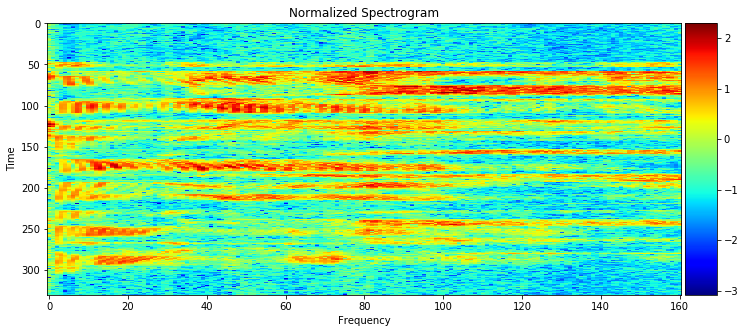

**Shape of Spectrogram** : (331, 161)

In [3]:
from data_generator import plot_spectrogram_feature

# plot normalized spectrogram
plot_spectrogram_feature(vis_spectrogram_feature)
# print shape of spectrogram
display(Markdown('**Shape of Spectrogram** : ' + str(vis_spectrogram_feature.shape)))

### Mel-Frequency Cepstral Coefficients (MFCCs)

The second option for an audio feature representation is [MFCCs](https://en.wikipedia.org/wiki/Mel-frequency_cepstrum).  You do **not** need to dig deeply into the details of how MFCCs are calculated, but if you would like more information, you are welcome to peruse the [documentation](https://github.com/jameslyons/python_speech_features) of the `python_speech_features` Python package.  Just as with the spectrogram features, the MFCCs are normalized in the supplied code.

The main idea behind MFCC features is the same as spectrogram features: at each time window, the MFCC feature yields a feature vector that characterizes the sound within the window.  Note that the MFCC feature is much lower-dimensional than the spectrogram feature, which could help an acoustic model to avoid overfitting to the training dataset. 

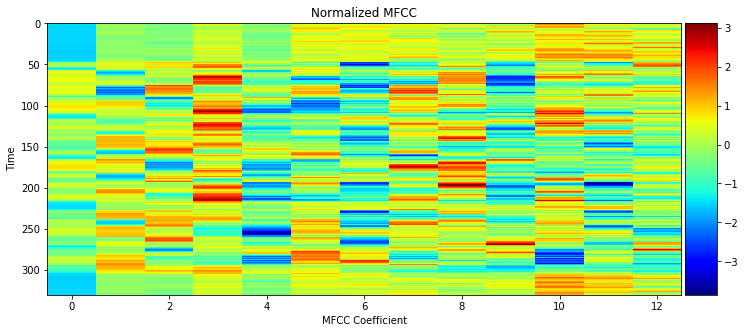

**Shape of MFCC** : (331, 13)

In [4]:
from data_generator import plot_mfcc_feature

# plot normalized MFCC
plot_mfcc_feature(vis_mfcc_feature)
# print shape of MFCC
display(Markdown('**Shape of MFCC** : ' + str(vis_mfcc_feature.shape)))

When you construct your pipeline, you will be able to choose to use either spectrogram or MFCC features.  If you would like to see different implementations that make use of MFCCs and/or spectrograms, please check out the links below:
- This [repository](https://github.com/baidu-research/ba-dls-deepspeech) uses spectrograms.
- This [repository](https://github.com/mozilla/DeepSpeech) uses MFCCs.
- This [repository](https://github.com/buriburisuri/speech-to-text-wavenet) also uses MFCCs.
- This [repository](https://github.com/pannous/tensorflow-speech-recognition/blob/master/speech_data.py) experiments with raw audio, spectrograms, and MFCCs as features.

<a id='step2'></a>
## STEP 2: Deep Neural Networks for Acoustic Modeling

In this section, you will experiment with various neural network architectures for acoustic modeling.  

You will begin by training five relatively simple architectures.  **Model 0** is provided for you.  You will write code to implement **Models 1**, **2**, **3**, and **4**.  If you would like to experiment further, you are welcome to create and train more models under the **Models 5+** heading.  

All models will be specified in the `sample_models.py` file.  After importing the `sample_models` module, you will train your architectures in the notebook.

After experimenting with the five simple architectures, you will have the opportunity to compare their performance.  Based on your findings, you will construct a deeper architecture that is designed to outperform all of the shallow models.

For your convenience, we have designed the notebook so that each model can be specified and trained on separate occasions.  That is, say you decide to take a break from the notebook after training **Model 1**.  Then, you need not re-execute all prior code cells in the notebook before training **Model 2**.  You need only re-execute the code cell below, that is marked with **`RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK`**, before transitioning to the code cells corresponding to **Model 2**.

In [2]:
#####################################################################
# RUN THIS CODE CELL IF YOU ARE RESUMING THE NOTEBOOK AFTER A BREAK #
#####################################################################

# allocate 50% of GPU memory (if you like, feel free to change this)
from keras.backend.tensorflow_backend import set_session
import tensorflow as tf 
config = tf.ConfigProto()
#config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

# watch for any changes in the sample_models module, and reload it automatically
%load_ext autoreload
%autoreload 2
# import NN architectures for speech recognition
from sample_models import *
# import function for training acoustic model
from train_utils import train_model

<a id='model0'></a>
### Model 0: RNN

Given their effectiveness in modeling sequential data, the first acoustic model you will use is an RNN.  As shown in the figure below, the RNN we supply to you will take the time sequence of audio features as input.

<img src="images/simple_rnn.png" width="50%">

At each time step, the speaker pronounces one of 28 possible characters, including each of the 26 letters in the English alphabet, along with a space character (" "), and an apostrophe (').

The output of the RNN at each time step is a vector of probabilities with 29 entries, where the $i$-th entry encodes the probability that the $i$-th character is spoken in the time sequence.  (The extra 29th character is an empty "character" used to pad training examples within batches containing uneven lengths.)  If you would like to peek under the hood at how characters are mapped to indices in the probability vector, look at the `char_map.py` file in the repository.  The figure below shows an equivalent, rolled depiction of the RNN that shows the output layer in greater detail. 

<img src="images/simple_rnn_unrolled.png" width="60%">

The model has already been specified for you in Keras.  To import it, you need only run the code cell below.  

In [6]:
model_0 = simple_rnn_model(input_dim=161) # change to 13 if you would like to use MFCC features

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 29)          16617     
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 16,617
Trainable params: 16,617
Non-trainable params: 0
_________________________________________________________________
None


As explored in the lesson, you will train the acoustic model with the [CTC loss](http://www.cs.toronto.edu/~graves/icml_2006.pdf) criterion.  Custom loss functions take a bit of hacking in Keras, and so we have implemented the CTC loss function for you, so that you can focus on trying out as many deep learning architectures as possible :).  If you'd like to peek at the implementation details, look at the `add_ctc_loss` function within the `train_utils.py` file in the repository.

To train your architecture, you will use the `train_model` function within the `train_utils` module; it has already been imported in one of the above code cells.  The `train_model` function takes three **required** arguments:
- `input_to_softmax` - a Keras model instance.
- `pickle_path` - the name of the pickle file where the loss history will be saved.
- `save_model_path` - the name of the HDF5 file where the model will be saved.

If we have already supplied values for `input_to_softmax`, `pickle_path`, and `save_model_path`, please **DO NOT** modify these values. 

There are several **optional** arguments that allow you to have more control over the training process.  You are welcome to, but not required to, supply your own values for these arguments.
- `minibatch_size` - the size of the minibatches that are generated while training the model (default: `20`).
- `spectrogram` - Boolean value dictating whether spectrogram (`True`) or MFCC (`False`) features are used for training (default: `True`).
- `mfcc_dim` - the size of the feature dimension to use when generating MFCC features (default: `13`).
- `optimizer` - the Keras optimizer used to train the model (default: `SGD(lr=0.02, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=5)`).  
- `epochs` - the number of epochs to use to train the model (default: `20`).  If you choose to modify this parameter, make sure that it is *at least* 20.
- `verbose` - controls the verbosity of the training output in the `model.fit_generator` method (default: `1`).
- `sort_by_duration` - Boolean value dictating whether the training and validation sets are sorted by (increasing) duration before the start of the first epoch (default: `False`).

The `train_model` function defaults to using spectrogram features; if you choose to use these features, note that the acoustic model in `simple_rnn_model` should have `input_dim=161`.  Otherwise, if you choose to use MFCC features, the acoustic model should have `input_dim=13`.

We have chosen to use `GRU` units in the supplied RNN.  If you would like to experiment with `LSTM` or `SimpleRNN` cells, feel free to do so here.  If you change the `GRU` units to `SimpleRNN` cells in `simple_rnn_model`, you may notice that the loss quickly becomes undefined (`nan`) - you are strongly encouraged to check this for yourself!  This is due to the [exploding gradients problem](http://www.wildml.com/2015/10/recurrent-neural-networks-tutorial-part-3-backpropagation-through-time-and-vanishing-gradients/).  We have already implemented [gradient clipping](https://arxiv.org/pdf/1211.5063.pdf) in your optimizer to help you avoid this issue.

__IMPORTANT NOTE:__ If you notice that your gradient has exploded in any of the models below, feel free to explore more with gradient clipping (the `clipnorm` argument in your optimizer) or swap out any `SimpleRNN` cells for `LSTM` or `GRU` cells.  You can also try restarting the kernel to restart the training process.

In [7]:
train_model(input_to_softmax=model_0, 
            pickle_path='model_0.pickle', 
            save_model_path='model_0.h5',
            minibatch_size=128,
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
16/16 [==============================] - 43s - loss: 1139.4797 - val_loss: 913.4268
Epoch 2/20
16/16 [==============================] - 40s - loss: 823.3807 - val_loss: 745.5252
Epoch 3/20
16/16 [==============================] - 40s - loss: 772.5124 - val_loss: 744.6868
Epoch 4/20
16/16 [==============================] - 40s - loss: 769.2979 - val_loss: 744.4792
Epoch 5/20
16/16 [==============================] - 41s - loss: 769.2079 - val_loss: 729.7808
Epoch 6/20
16/16 [==============================] - 40s - loss: 759.7496 - val_loss: 730.4523
Epoch 7/20
16/16 [==============================] - 41s - loss: 760.6221 - val_loss: 729.3428
Epoch 8/20
16/16 [==============================] - 39s - loss: 752.0476 - val_loss: 723.1729
Epoch 9/20
16/16 [==============================] - 40s - loss: 753.9854 - val_loss: 729.9603
Epoch 10/20
16/16 [==============================] - 40s - loss: 751.1980 - val_loss: 731.5267
Epoch 11/20
16/16 [==============================] - 40s -

<a id='model1'></a>
### (IMPLEMENTATION) Model 1: RNN + TimeDistributed Dense

Read about the [TimeDistributed](https://keras.io/layers/wrappers/) wrapper and the [BatchNormalization](https://keras.io/layers/normalization/) layer in the Keras documentation.  For your next architecture, you will add [batch normalization](https://arxiv.org/pdf/1510.01378.pdf) to the recurrent layer to reduce training times.  The `TimeDistributed` layer will be used to find more complex patterns in the dataset.  The unrolled snapshot of the architecture is depicted below.

<img src="images/rnn_model.png" width="60%">

The next figure shows an equivalent, rolled depiction of the RNN that shows the (`TimeDistrbuted`) dense and output layers in greater detail.  

<img src="images/rnn_model_unrolled.png" width="60%">

Use your research to complete the `rnn_model` function within the `sample_models.py` file.  The function should specify an architecture that satisfies the following requirements:
- The first layer of the neural network should be an RNN (`SimpleRNN`, `LSTM`, or `GRU`) that takes the time sequence of audio features as input.  We have added `GRU` units for you, but feel free to change `GRU` to `SimpleRNN` or `LSTM`, if you like!
- Whereas the architecture in `simple_rnn_model` treated the RNN output as the final layer of the model, you will use the output of your RNN as a hidden layer.  Use `TimeDistributed` to apply a `Dense` layer to each of the time steps in the RNN output.  Ensure that each `Dense` layer has `output_dim` units.

Use the code cell below to load your model into the `model_1` variable.  Use a value for `input_dim` that matches your chosen audio features, and feel free to change the values for `units` and `activation` to tweak the behavior of your recurrent layer.

In [8]:
model_1 = rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                    units=10,
                    activation='relu')

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn (GRU)                    (None, None, 10)          5160      
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 10)          40        
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          319       
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 5,519
Trainable params: 5,499
Non-trainable params: 20
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_1.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_1.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [9]:
train_model(input_to_softmax=model_1, 
            pickle_path='model_1.pickle', 
            save_model_path='model_1.h5',
            minibatch_size=128,
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
16/16 [==============================] - 42s - loss: 615.2308 - val_loss: 393.2212
Epoch 2/20
16/16 [==============================] - 40s - loss: 256.7423 - val_loss: 275.8740
Epoch 3/20
16/16 [==============================] - 41s - loss: 230.9604 - val_loss: 225.1616
Epoch 4/20
16/16 [==============================] - 41s - loss: 226.6911 - val_loss: 217.7921
Epoch 5/20
16/16 [==============================] - 40s - loss: 226.2769 - val_loss: 222.9837
Epoch 6/20
16/16 [==============================] - 41s - loss: 225.0238 - val_loss: 218.3127
Epoch 7/20
16/16 [==============================] - 40s - loss: 225.1596 - val_loss: 213.2416
Epoch 8/20
16/16 [==============================] - 39s - loss: 225.1785 - val_loss: 212.6484
Epoch 9/20
16/16 [==============================] - 40s - loss: 224.8974 - val_loss: 213.3634
Epoch 10/20
16/16 [==============================] - 39s - loss: 222.6987 - val_loss: 208.6887
Epoch 11/20
16/16 [==============================] - 40s - 

<a id='model2'></a>
### (IMPLEMENTATION) Model 2: CNN + RNN + TimeDistributed Dense

The architecture in `cnn_rnn_model` adds an additional level of complexity, by introducing a [1D convolution layer](https://keras.io/layers/convolutional/#conv1d).  

<img src="images/cnn_rnn_model.png" width="100%">

This layer incorporates many arguments that can be (optionally) tuned when calling the `cnn_rnn_model` module.  We provide sample starting parameters, which you might find useful if you choose to use spectrogram audio features.  

If you instead want to use MFCC features, these arguments will have to be tuned.  Note that the current architecture only supports values of `'same'` or `'valid'` for the `conv_border_mode` argument.

When tuning the parameters, be careful not to choose settings that make the convolutional layer overly small.  If the temporal length of the CNN layer is shorter than the length of the transcribed text label, your code will throw an error.

Before running the code cell below, you must modify the `cnn_rnn_model` function in `sample_models.py`.  Please add batch normalization to the recurrent layer, and provide the same `TimeDistributed` layer as before.

In [12]:
model_2 = cnn_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        filters=200,
                        kernel_size=11, 
                        conv_stride=2,
                        conv_border_mode='valid',
                        units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
conv1d (Conv1D)              (None, None, 200)         354400    
_________________________________________________________________
bn_conv_1d (BatchNormalizati (None, None, 200)         800       
_________________________________________________________________
rnn (SimpleRNN)              (None, None, 200)         80200     
_________________________________________________________________
batch_normalization_3 (Batch (None, None, 200)         800       
_________________________________________________________________
time_distributed_3 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_2.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_2.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [14]:
train_model(input_to_softmax=model_2, 
            pickle_path='model_2.pickle', 
            save_model_path='model_2.h5',
            minibatch_size=64, 
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
33/33 [==============================] - 23s - loss: 232.8567 - val_loss: 249.9025
Epoch 2/20
33/33 [==============================] - 22s - loss: 197.4467 - val_loss: 217.1720
Epoch 3/20
33/33 [==============================] - 21s - loss: 174.2714 - val_loss: 183.6967
Epoch 4/20
33/33 [==============================] - 21s - loss: 160.0410 - val_loss: 164.9208
Epoch 5/20
33/33 [==============================] - 22s - loss: 148.2059 - val_loss: 157.8018
Epoch 6/20
33/33 [==============================] - 21s - loss: 141.7872 - val_loss: 148.7940
Epoch 7/20
33/33 [==============================] - 22s - loss: 134.5172 - val_loss: 147.7318
Epoch 8/20
33/33 [==============================] - 22s - loss: 129.7783 - val_loss: 143.0564
Epoch 9/20
33/33 [==============================] - 22s - loss: 124.9983 - val_loss: 139.8131
Epoch 10/20
33/33 [==============================] - 21s - loss: 120.2713 - val_loss: 138.9137
Epoch 11/20
33/33 [==============================] - 21s - 

<a id='model3'></a>
### (IMPLEMENTATION) Model 3: Deeper RNN + TimeDistributed Dense

Review the code in `rnn_model`, which makes use of a single recurrent layer.  Now, specify an architecture in `deep_rnn_model` that utilizes a variable number `recur_layers` of recurrent layers.  The figure below shows the architecture that should be returned if `recur_layers=2`.  In the figure, the output sequence of the first recurrent layer is used as input for the next recurrent layer.

<img src="images/deep_rnn_model.png" width="80%">

Feel free to change the supplied values of `units` to whatever you think performs best.  You can change the value of `recur_layers`, as long as your final value is greater than 1. (As a quick check that you have implemented the additional functionality in `deep_rnn_model` correctly, make sure that the architecture that you specify here is identical to `rnn_model` if `recur_layers=1`.)

In [2]:
model_3 = deep_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                         units=200,
                         recur_layers=2) 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
rnn_0 (GRU)                  (None, None, 200)         217200    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 200)         800       
_________________________________________________________________
rnn_1 (GRU)                  (None, None, 200)         240600    
_________________________________________________________________
batch_normalization_2 (Batch (None, None, 200)         800       
_________________________________________________________________
time_distributed_1 (TimeDist (None, None, 29)          5829      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total para

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_3.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_3.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [3]:
train_model(input_to_softmax=model_3, 
            pickle_path='model_3.pickle', 
            save_model_path='model_3.h5',
            minibatch_size=128,
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
16/16 [==============================] - 60s - loss: 448.4092 - val_loss: 515.5186
Epoch 2/20
16/16 [==============================] - 57s - loss: 260.0460 - val_loss: 668.4569
Epoch 3/20
16/16 [==============================] - 57s - loss: 235.1759 - val_loss: 505.0856
Epoch 4/20
16/16 [==============================] - 58s - loss: 229.3215 - val_loss: 366.1711
Epoch 5/20
16/16 [==============================] - 58s - loss: 217.5171 - val_loss: 318.7695
Epoch 6/20
16/16 [==============================] - 57s - loss: 211.9238 - val_loss: 374.5540
Epoch 7/20
16/16 [==============================] - 57s - loss: 206.9911 - val_loss: 349.3010
Epoch 8/20
16/16 [==============================] - 58s - loss: 202.2084 - val_loss: 310.3368
Epoch 9/20
16/16 [==============================] - 57s - loss: 195.5573 - val_loss: 285.6031
Epoch 10/20
16/16 [==============================] - 57s - loss: 190.9249 - val_loss: 280.6886
Epoch 11/20
16/16 [==============================] - 58s - 

<a id='model4'></a>
### (IMPLEMENTATION) Model 4: Bidirectional RNN + TimeDistributed Dense

Read about the [Bidirectional](https://keras.io/layers/wrappers/) wrapper in the Keras documentation.  For your next architecture, you will specify an architecture that uses a single bidirectional RNN layer, before a (`TimeDistributed`) dense layer.  The added value of a bidirectional RNN is described well in [this paper](http://www.cs.toronto.edu/~hinton/absps/DRNN_speech.pdf).
> One shortcoming of conventional RNNs is that they are only able to make use of previous context. In speech recognition, where whole utterances are transcribed at once, there is no reason not to exploit future context as well.  Bidirectional RNNs (BRNNs) do this by processing the data in both directions with two separate hidden layers which are then fed forwards to the same output layer.

<img src="images/bidirectional_rnn_model.png" width="80%">

Before running the code cell below, you must complete the `bidirectional_rnn_model` function in `sample_models.py`.  Feel free to use `SimpleRNN`, `LSTM`, or `GRU` units.  When specifying the `Bidirectional` wrapper, use `merge_mode='concat'`.

In [4]:
model_4 = bidirectional_rnn_model(input_dim=161, # change to 13 if you would like to use MFCC features
                                  units=200)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
the_input (InputLayer)       (None, None, 161)         0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 58)          33234     
_________________________________________________________________
time_distributed_2 (TimeDist (None, None, 29)          1711      
_________________________________________________________________
softmax (Activation)         (None, None, 29)          0         
Total params: 34,945
Trainable params: 34,945
Non-trainable params: 0
_________________________________________________________________
None


Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_4.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_4.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [5]:
train_model(input_to_softmax=model_4, 
            pickle_path='model_4.pickle', 
            save_model_path='model_4.h5',
            minibatch_size=128,
            spectrogram=True) # change to False if you would like to use MFCC features

Epoch 1/20
16/16 [==============================] - 57s - loss: 482.5365 - val_loss: 248.7864
Epoch 2/20
16/16 [==============================] - 55s - loss: 249.4718 - val_loss: 232.4691
Epoch 3/20
16/16 [==============================] - 54s - loss: 241.4920 - val_loss: 227.8975
Epoch 4/20
16/16 [==============================] - 55s - loss: 238.0911 - val_loss: 228.6751
Epoch 5/20
16/16 [==============================] - 55s - loss: 236.0029 - val_loss: 226.2960
Epoch 6/20
16/16 [==============================] - 55s - loss: 234.6311 - val_loss: 226.0875
Epoch 7/20
16/16 [==============================] - 54s - loss: 232.3436 - val_loss: 224.0487
Epoch 8/20
16/16 [==============================] - 55s - loss: 231.1823 - val_loss: 221.0543
Epoch 9/20
16/16 [==============================] - 55s - loss: 229.8245 - val_loss: 221.0060
Epoch 10/20
16/16 [==============================] - 54s - loss: 227.3047 - val_loss: 217.2681
Epoch 11/20
16/16 [==============================] - 54s - 

<a id='model5'></a>
### (OPTIONAL IMPLEMENTATION) Models 5+

If you would like to try out more architectures than the ones above, please use the code cell below.  Please continue to follow the same convention for saving the models; for the $i$-th sample model, please save the loss at **`model_i.pickle`** and saving the trained model at **`model_i.h5`**.

In [6]:
## (Optional) TODO: Try out some more models!
### Feel free to use as many code cells as needed.


#### **My reference Model : Conv1D -> RELU -> Batch Normalization -> Bidirectional GRU -> Batch Normalization -> Fully Connected**

My final_model implementation allows to specify lots of parameters values. Below I have defined my base model on which I will test the impact of some parameters value change (one parameter change at a time). My goal is to identify some key parameter values in order to complete the final model for this project.

**Note** : Identifying good working individual parameters does not guarantee that they will perform optimally all together (Some parameters combinations might even conflict together...) In order to find an optimal solution, a full parameter grid search should be performed, but as it is very time consumming/heavy computing for this project, I choose a more empirical approach


In [3]:
from keras.optimizers import SGD

# specify the model
model_end = final_model(input_dim=161, # change to 13 if you would like to use MFCC features 
                     # CNN parameters
                     cnn_layers = 1,
                     filters=200, kernel_size=11, conv_stride=2, conv_border_mode='valid', dilation=1,
                     cnn_implementation='BN-DR-AC',
                     cnn_dropout=0.3,
                     cnn_activation='relu',
                     # RNN parameters
                     reccur_units=200,  
                     recur_layers=2,
                     recur_type='GRU',
                     recur_implementation=2,
                     reccur_droput=0.3,
                     recurrent_dropout=0.1, 
                     reccur_merge_mode='sum', 
                     # Fully Connected layer parameters
                     fc_units=[200],  # Note: Output layer ofs ize 29 is automatically added in the model
                     fc_dropout=0.3,
                     fc_activation='relu')

from keras.optimizers import SGD

train_model(input_to_softmax=model_end,
            epochs=30, 
            minibatch_size=128, ##### Adjust batch size
            optimizer=SGD(lr=0.025, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=4.0),
            sort_by_duration=True,
            pickle_path='model_5.pickle', 
            save_model_path='model_5.h5',
            train_json='train_corpus.json',
            spectrogram=True) # change to False if you would like to use MFCC features 
    

______________________________________________________________________________________________________________
Layer (type)                                     Output Shape                                Param #          
the_input (InputLayer)                           (None, None, 161)                           0                
______________________________________________________________________________________________________________
cnn_0 (Conv1D)                                   (None, None, 200)                           354400           
______________________________________________________________________________________________________________
bn_cnn_0 (BatchNormalization)                    (None, None, 200)                           800              
______________________________________________________________________________________________________________
drop_cnn_0 (Dropout)                             (None, None, 200)                           0                
_

#### **Variation over my reference model : compare GRU vs LSTM for the reccurent layers**

In [4]:
from keras.optimizers import SGD

# specify the model
model_end = final_model(input_dim=161, # change to 13 if you would like to use MFCC features 
                     # CNN parameters
                     cnn_layers = 1,
                     filters=200, kernel_size=11, conv_stride=2, conv_border_mode='valid', dilation=1,
                     cnn_implementation='BN-DR-AC',
                     cnn_dropout=0.3,
                     cnn_activation='relu',
                     # RNN parameters
                     reccur_units=200,  
                     recur_layers=2,
                     recur_type='LSTM',
                     recur_implementation=2,
                     reccur_droput=0.3,
                     recurrent_dropout=0.1, 
                     reccur_merge_mode='sum', 
                     # Fully Connected layer parameters
                     fc_units=[200],  # Note: Output layer ofs ize 29 is automatically added in the model
                     fc_dropout=0.3,
                     fc_activation='relu')

from keras.optimizers import SGD

train_model(input_to_softmax=model_end,
            epochs=30, 
            minibatch_size=128, ##### Adjust batch size
            optimizer=SGD(lr=0.025, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=4.0),
            sort_by_duration=True,
            pickle_path='model_6.pickle', 
            save_model_path='model_6.h5',
            train_json='train_corpus.json',
            spectrogram=True) # change to False if you would like to use MFCC features 
    

______________________________________________________________________________________________________________
Layer (type)                                     Output Shape                                Param #          
the_input (InputLayer)                           (None, None, 161)                           0                
______________________________________________________________________________________________________________
cnn_0 (Conv1D)                                   (None, None, 200)                           354400           
______________________________________________________________________________________________________________
bn_cnn_0 (BatchNormalization)                    (None, None, 200)                           800              
______________________________________________________________________________________________________________
drop_cnn_0 (Dropout)                             (None, None, 200)                           0                
_

#### **Variation over my reference model : compare 'concat' versus 'sum' in the merge function of the Bidirectional RNN layers**

In [5]:
from keras.optimizers import SGD

# specify the model
model_end = final_model(input_dim=161, # change to 13 if you would like to use MFCC features 
                     # CNN parameters
                     cnn_layers = 1,
                     filters=200, kernel_size=11, conv_stride=2, conv_border_mode='valid', dilation=1,
                     cnn_implementation='BN-DR-AC',
                     cnn_dropout=0.3,
                     cnn_activation='relu',
                     # RNN parameters
                     reccur_units=200,  
                     recur_layers=2,
                     recur_type='GRU',
                     recur_implementation=2,
                     reccur_droput=0.3,
                     recurrent_dropout=0.1, 
                     reccur_merge_mode='concat', 
                     # Fully Connected layer parameters
                     fc_units=[200],  # Note: Output layer ofs ize 29 is automatically added in the model
                     fc_dropout=0.3,
                     fc_activation='relu')

from keras.optimizers import SGD

train_model(input_to_softmax=model_end,
            epochs=30, 
            minibatch_size=128, ##### Adjust batch size
            optimizer=SGD(lr=0.025, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=4.0),
            sort_by_duration=True,
            pickle_path='model_7.pickle', 
            save_model_path='model_7.h5',
            train_json='train_corpus.json',
            spectrogram=True) # change to False if you would like to use MFCC features 
    

______________________________________________________________________________________________________________
Layer (type)                                     Output Shape                                Param #          
the_input (InputLayer)                           (None, None, 161)                           0                
______________________________________________________________________________________________________________
cnn_0 (Conv1D)                                   (None, None, 200)                           354400           
______________________________________________________________________________________________________________
bn_cnn_0 (BatchNormalization)                    (None, None, 200)                           800              
______________________________________________________________________________________________________________
drop_cnn_0 (Dropout)                             (None, None, 200)                           0                
_

#### **Variation over my base model : compare the impact on using a Spectrogram or MFCC input format **

In [6]:
from keras.optimizers import SGD

# specify the model
model_end = final_model(input_dim=13, 
                     # CNN parameters
                     cnn_layers = 1,
                     filters=200, kernel_size=11, conv_stride=2, conv_border_mode='valid', dilation=1,
                     cnn_implementation='BN-DR-AC',
                     cnn_dropout=0.3,
                     cnn_activation='relu',
                     # RNN parameters
                     reccur_units=200,  
                     recur_layers=2,
                     recur_type='GRU',
                     recur_implementation=2,
                     reccur_droput=0.3,
                     recurrent_dropout=0.1, 
                     reccur_merge_mode='sum', 
                     # Fully Connected layer parameters
                     fc_units=[200],  # Note: Output layer ofs ize 29 is automatically added in the model
                     fc_dropout=0.3,
                     fc_activation='relu')

from keras.optimizers import SGD

train_model(input_to_softmax=model_end,
            epochs=30, 
            minibatch_size=128, ##### Adjust batch size
            optimizer=SGD(lr=0.025, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=4.0),
            sort_by_duration=True,
            pickle_path='model_8.pickle', 
            save_model_path='model_8.h5',
            train_json='train_corpus.json',
            spectrogram=False) 
    

______________________________________________________________________________________________________________
Layer (type)                                     Output Shape                                Param #          
the_input (InputLayer)                           (None, None, 13)                            0                
______________________________________________________________________________________________________________
cnn_0 (Conv1D)                                   (None, None, 200)                           28800            
______________________________________________________________________________________________________________
bn_cnn_0 (BatchNormalization)                    (None, None, 200)                           800              
______________________________________________________________________________________________________________
drop_cnn_0 (Dropout)                             (None, None, 200)                           0                
_

#### **Variation over my reference model : compare the impact of using a padding 'same' instade of 'valid' in the convolution layer**

In [7]:
from keras.optimizers import SGD

# specify the model
model_end = final_model(input_dim=161, # change to 13 if you would like to use MFCC features 
                     # CNN parameters
                     cnn_layers = 1,
                     filters=200, kernel_size=11, conv_stride=2, conv_border_mode='same', dilation=1,
                     cnn_implementation='BN-DR-AC',
                     cnn_dropout=0.3,
                     cnn_activation='relu',
                     # RNN parameters
                     reccur_units=200,  
                     recur_layers=2,
                     recur_type='GRU',
                     recur_implementation=2,
                     reccur_droput=0.3,
                     recurrent_dropout=0.1, 
                     reccur_merge_mode='sum', 
                     # Fully Connected layer parameters
                     fc_units=[200],  # Note: Output layer ofs ize 29 is automatically added in the model
                     fc_dropout=0.3,
                     fc_activation='relu')

from keras.optimizers import SGD

train_model(input_to_softmax=model_end,
            epochs=30, 
            minibatch_size=128, ##### Adjust batch size
            optimizer=SGD(lr=0.025, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=4.0),
            sort_by_duration=True,
            pickle_path='model_9.pickle', 
            save_model_path='model_9.h5',
            train_json='train_corpus.json',
            spectrogram=True) # change to False if you would like to use MFCC features 
    

______________________________________________________________________________________________________________
Layer (type)                                     Output Shape                                Param #          
the_input (InputLayer)                           (None, None, 161)                           0                
______________________________________________________________________________________________________________
cnn_0 (Conv1D)                                   (None, None, 200)                           354400           
______________________________________________________________________________________________________________
bn_cnn_0 (BatchNormalization)                    (None, None, 200)                           800              
______________________________________________________________________________________________________________
drop_cnn_0 (Dropout)                             (None, None, 200)                           0                
_

#### **Variation over my reference model : compare the impact of using a dilation of 2 in the convolution layer (padding 'same'+stride=1) **

In [8]:
from keras.optimizers import SGD

# specify the model
model_end = final_model(input_dim=161, # change to 13 if you would like to use MFCC features 
                     # CNN parameters
                     cnn_layers = 1,
                     filters=200, kernel_size=11, conv_stride=1, conv_border_mode='same', dilation=2,
                     cnn_implementation='BN-DR-AC',
                     cnn_dropout=0.3,
                     cnn_activation='relu',
                     # RNN parameters
                     reccur_units=200,  
                     recur_layers=2,
                     recur_type='GRU',
                     recur_implementation=2,
                     reccur_droput=0.3,
                     recurrent_dropout=0.1, 
                     reccur_merge_mode='sum', 
                     # Fully Connected layer parameters
                     fc_units=[200],  # Note: Output layer ofs ize 29 is automatically added in the model
                     fc_dropout=0.3,
                     fc_activation='relu')

from keras.optimizers import SGD

train_model(input_to_softmax=model_end,
            epochs=30, 
            minibatch_size=128, ##### Adjust batch size
            optimizer=SGD(lr=0.025, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=4.0),
            sort_by_duration=True,
            pickle_path='model_10.pickle', 
            save_model_path='model_10.h5',
            train_json='train_corpus.json',
            spectrogram=True) # change to False if you would like to use MFCC features 
    

______________________________________________________________________________________________________________
Layer (type)                                     Output Shape                                Param #          
the_input (InputLayer)                           (None, None, 161)                           0                
______________________________________________________________________________________________________________
cnn_0 (Conv1D)                                   (None, None, 200)                           354400           
______________________________________________________________________________________________________________
bn_cnn_0 (BatchNormalization)                    (None, None, 200)                           800              
______________________________________________________________________________________________________________
drop_cnn_0 (Dropout)                             (None, None, 200)                           0                
_

#### **Variation over my reference model : compare the impact of using a dilation of 2 with 2 convolution layers (padding 'same'+stride=1) **

In [9]:
from keras.optimizers import SGD

# specify the model
model_end = final_model(input_dim=161, # change to 13 if you would like to use MFCC features 
                     # CNN parameters
                     cnn_layers = 2,
                     filters=200, kernel_size=11, conv_stride=1, conv_border_mode='same', dilation=2,
                     cnn_implementation='BN-DR-AC',
                     cnn_dropout=0.3,
                     cnn_activation='relu',
                     # RNN parameters=
                     reccur_units=200,  
                     recur_layers=2,
                     recur_type='GRU',
                     recur_implementation=2,
                     reccur_droput=0.3,
                     recurrent_dropout=0.1, 
                     reccur_merge_mode='sum', 
                     # Fully Connected layer parameters
                     fc_units=[200],  # Note: Output layer ofs ize 29 is automatically added in the model
                     fc_dropout=0.3,
                     fc_activation='relu')

from keras.optimizers import SGD

train_model(input_to_softmax=model_end,
            epochs=30, =
            minibatch_size=128, ##### Adjust batch size
            optimizer=SGD(lr=0.025, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=4.0),
            sort_by_duration=True,
            pickle_path='model_11.pickle', 
            save_model_path='model_11.h5',
            train_json='train_corpus.json',
            spectrogram=True) # change to False if you would like to use MFCC features 
    

______________________________________________________________________________________________________________
Layer (type)                                     Output Shape                                Param #          
the_input (InputLayer)                           (None, None, 161)                           0                
______________________________________________________________________________________________________________
cnn_0 (Conv1D)                                   (None, None, 200)                           354400           
______________________________________________________________________________________________________________
bn_cnn_0 (BatchNormalization)                    (None, None, 200)                           800              
______________________________________________________________________________________________________________
drop_cnn_0 (Dropout)                             (None, None, 200)                           0                
_

#### **Variation over my reference model : compare the impact of using a dilation of 4 with 2 convolution layers (padding 'same'+stride=1) **

In [4]:
from keras.optimizers import SGD

# specify the model
model_end = final_model(input_dim=161, # change to 13 if you would like to use MFCC features 
                     # CNN parameters
                     cnn_layers = 2,
                     filters=200, kernel_size=11, conv_stride=1, conv_border_mode='same', dilation=2,
                     cnn_implementation='BN-DR-AC',
                     cnn_dropout=0.3,
                     cnn_activation='relu',
                     # RNN parameters=
                     reccur_units=200,  
                     recur_layers=2,
                     recur_type='GRU',
                     recur_implementation=2,
                     reccur_droput=0.3,
                     recurrent_dropout=0.1, 
                     reccur_merge_mode='sum', 
                     # Fully Connected layer parameters
                     fc_units=[200],  # Note: Output layer ofs ize 29 is automatically added in the model
                     fc_dropout=0.3,
                     fc_activation='relu')

from keras.optimizers import SGD

train_model(input_to_softmax=model_end,
            epochs=30, 
            minibatch_size=128, ##### Adjust batch size
            optimizer=SGD(lr=0.025, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=4.0),
            sort_by_duration=True,
            pickle_path='model_12.pickle', 
            save_model_path='model_12.h5',
            train_json='train_corpus.json',
            spectrogram=True) # change to False if you would like to use MFCC features 
    

______________________________________________________________________________________________________________
Layer (type)                                     Output Shape                                Param #          
the_input (InputLayer)                           (None, None, 161)                           0                
______________________________________________________________________________________________________________
cnn_0 (Conv1D)                                   (None, None, 200)                           354400           
______________________________________________________________________________________________________________
bn_cnn_0 (BatchNormalization)                    (None, None, 200)                           800              
______________________________________________________________________________________________________________
drop_cnn_0 (Dropout)                             (None, None, 200)                           0                
_

#### **Final model trained on 30 epochs and development training set **

In [5]:
# specify the model
model_end = final_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        # CNN parameters
                        cnn_layers =3,
                        filters=350, kernel_size=11, conv_stride=1, conv_border_mode='same', dilation=4,
                        cnn_implementation='BN-DR-AC',
                        cnn_dropout=0.3,
                        cnn_activation='relu',
                        # RNN parameters
                        reccur_units=200,  #29,
                        recur_layers=3,
                        recur_type='LSTM',
                        recur_implementation=2,
                        reccur_droput=0.3,
                        recurrent_dropout=0.1, 
                        reccur_merge_mode='sum', 
                        # Fully Connected layer parameters
                        fc_units=[400, 200, 100],
                        fc_dropout=0.3,
                        fc_activation='relu')

from keras.optimizers import SGD

train_model(input_to_softmax=model_end,
            epochs=30, 
            minibatch_size=128, ##### Adjust batch size
            optimizer=SGD(lr=0.025, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=4.0),
            sort_by_duration=True,
            pickle_path='model_candidate.pickle', 
            save_model_path='model_candidate.h5',
            train_json='train_corpus.json',
            spectrogram=True) # change to False if you would like to use MFCC features 

______________________________________________________________________________________________________________
Layer (type)                                     Output Shape                                Param #          
the_input (InputLayer)                           (None, None, 161)                           0                
______________________________________________________________________________________________________________
cnn_0 (Conv1D)                                   (None, None, 350)                           620200           
______________________________________________________________________________________________________________
bn_cnn_0 (BatchNormalization)                    (None, None, 350)                           1400             
______________________________________________________________________________________________________________
drop_cnn_0 (Dropout)                             (None, None, 350)                           0                
_

**TODO conclusion**:

Our reference base model performance was:  






<a id='compare'></a>
### Compare the Models

Execute the code cell below to evaluate the performance of the drafted deep learning models.  The training and validation loss are plotted for each model.

/opt/DataScience/lib/python3.5/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)
/opt/DataScience/lib/python3.5/site-packages/matplotlib/font_manager.py:1328: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


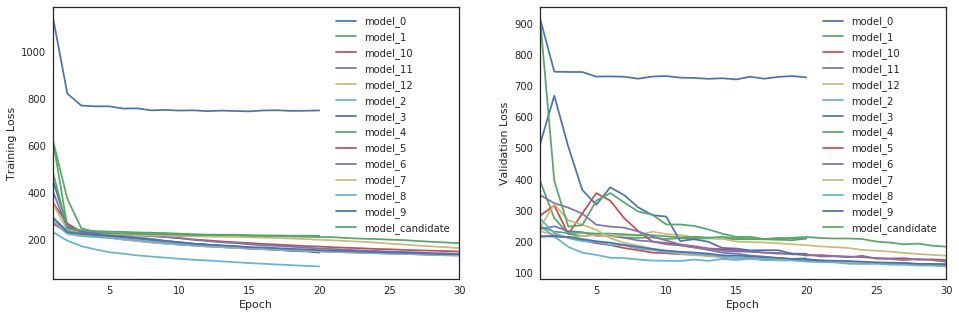

In [6]:
from glob import glob
import numpy as np
import _pickle as pickle
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
sns.set_style(style='white')

# obtain the paths for the saved model history
all_pickles = sorted(glob("results/*.pickle"))
# extract the name of each model
model_names = [item[8:-7] for item in all_pickles]
# extract the loss history for each model
valid_loss = [pickle.load( open( i, "rb" ) )['val_loss'] for i in all_pickles]
train_loss = [pickle.load( open( i, "rb" ) )['loss'] for i in all_pickles]
# save the number of epochs used to train each model
num_epochs = [len(valid_loss[i]) for i in range(len(valid_loss))]

fig = plt.figure(figsize=(16,5))

# plot the training loss vs. epoch for each model
ax1 = fig.add_subplot(121)
for i in range(len(all_pickles)):
    ax1.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            train_loss[i], label=model_names[i])
# clean up the plot
ax1.legend()  
ax1.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Training Loss')

# plot the validation loss vs. epoch for each model
ax2 = fig.add_subplot(122)
for i in range(len(all_pickles)):
    ax2.plot(np.linspace(1, num_epochs[i], num_epochs[i]), 
            valid_loss[i], label=model_names[i])
# clean up the plot
ax2.legend()  
ax2.set_xlim([1, max(num_epochs)])
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.show()

__Question 1:__ Use the plot above to analyze the performance of each of the attempted architectures.  Which performs best?  Provide an explanation regarding why you think some models perform better than others. 

__Answer:__

- Model 0 (29 GRU cells) is to small/basic to learn and generalize properly
- Model 1 (10 GRU -> 29 TimeDistributed) performs much better than model 0, mostly due to the TimeDistributed wrapper which allow to apply the dense layer on each timestep. However this model, is not large enough to learn the complexity of the dataset. Also just increasing the number of RNN cells does not help as it cause gradient issues (causing NaN output), even when using batch Normalization (Maybe tweaking the initializations would help a bit)
- Model 2 (200 CNN -> 200 GRU -> 29 TimeDistributed) perfomed the best. The 1D temporal convolution really helps to extract features from the spectrogram and boost the model performance
- Model 3 (200 GRU -> 200 GRU -> 29 TimeDistributed) performed quite good too. Stacking more reccurent layers, and using batchnormalization, help to better learn the temporal data
- Model 4 (200 Bi-directional GRU -> 9 TimeDistributed) performed quite good too, but as it had less capacity (GRU Cells) than model_3, so it did not produce better results here. 

Base on these results, it was clear to me that I should combine all the best characteristics of these models, thus using 1D convolution at the input, stacking several Bidirectional RNN layers, adding a few more time distributed dense layers and of course using batch normalization. Here comes model_5 :

- Model 5 ( 200 Conv1D -> RELU -> Batch Normalization -> 200 Bidirectional GRU -> -> 200 Bidirectional GRU -> Batch Normalization -> -> 200 TimeDistributed) is my reference model to investigate the impact of some other parameters/architecture choices. Thismodel performed amongsthe best ones.

I also decided to investigate a few more parameters / architecture variationsaround model_5 :

- Model 6 : Impact of GRU vs LSTM : not significative difference in our small test. However we can expect LSTM to sligtly perform better but also be more compute hungry. Without major impacton the training time noticed with my setup, I will use LSTM in my final model.

- Model 7 : Impact of merging mode for the biddirectional RNN layers (Sum vs Concat) : Here again, no major impact noticed. In my final model, I will use "sum" as used by DeepSpeech

- Model 8 : Impact of using MFCC features vs Spectrogram features : in the small test, using the MFCC features at the input performed slightly better taht usingthe spectrogram. Having elssfeatures(13 instead of 161) works a bit better on a relaivelysmall model. As I plan to use a bigger model and use a larger dataset, I will still use the spectrogram features at the input. My intuition is that having more features will work better with the convolution layers.

- Model 9 : Impact of using 'same' versus 'valid' paddingin the convolution layer. Here again, no major impact noticed. In my final model, I will use "same" as I plan to stack several conv1D layers (For the moment I only have managed to make it work with 'same" padding)

- Model 10 : Impact of using 1 convolution layer with dilation rate of 2 : Slighty worst results on this small test run. Probably linked to the reduce stride imposed in Keras ("Currently, specifying any dilation_rate value != 1 is incompatible with specifying any strides value != 1.")

- Model 11 : Impact of using 2 Convolution layers with a dilation rate of 2 : quite good results on teh small test run

- Model 12 : Impact of using 2 Convolution layers with a dilation rate of 4 : quite good with lighty worst results on this small test run. However I will probably use this setting for my final model (which will be larger and that will be trained  with a larger dataset (training set of 360 hours "clean" speech ) 

<a id='final'></a>
### (IMPLEMENTATION) Final Model

Now that you've tried out many sample models, use what you've learned to draft your own architecture!  While your final acoustic model should not be identical to any of the architectures explored above, you are welcome to merely combine the explored layers above into a deeper architecture.  It is **NOT** necessary to include new layer types that were not explored in the notebook.

However, if you would like some ideas for even more layer types, check out these ideas for some additional, optional extensions to your model:

- If you notice your model is overfitting to the training dataset, consider adding **dropout**!  To add dropout to [recurrent layers](https://faroit.github.io/keras-docs/1.0.2/layers/recurrent/), pay special attention to the `dropout_W` and `dropout_U` arguments.  This [paper](http://arxiv.org/abs/1512.05287) may also provide some interesting theoretical background.
- If you choose to include a convolutional layer in your model, you may get better results by working with **dilated convolutions**.  If you choose to use dilated convolutions, make sure that you are able to accurately calculate the length of the acoustic model's output in the `model.output_length` lambda function.  You can read more about dilated convolutions in Google's [WaveNet paper](https://arxiv.org/abs/1609.03499).  For an example of a speech-to-text system that makes use of dilated convolutions, check out this GitHub [repository](https://github.com/buriburisuri/speech-to-text-wavenet).  You can work with dilated convolutions [in Keras](https://keras.io/layers/convolutional/) by paying special attention to the `padding` argument when you specify a convolutional layer.
- If your model makes use of convolutional layers, why not also experiment with adding **max pooling**?  Check out [this paper](https://arxiv.org/pdf/1701.02720.pdf) for example architecture that makes use of max pooling in an acoustic model.
- So far, you have experimented with a single bidirectional RNN layer.  Consider stacking the bidirectional layers, to produce a [deep bidirectional RNN](https://www.cs.toronto.edu/~graves/asru_2013.pdf)!

All models that you specify in this repository should have `output_length` defined as an attribute.  This attribute is a lambda function that maps the (temporal) length of the input acoustic features to the (temporal) length of the output softmax layer.  This function is used in the computation of CTC loss; to see this, look at the `add_ctc_loss` function in `train_utils.py`.  To see where the `output_length` attribute is defined for the models in the code, take a look at the `sample_models.py` file.  You will notice this line of code within most models:
```
model.output_length = lambda x: x
```
The acoustic model that incorporates a convolutional layer (`cnn_rnn_model`) has a line that is a bit different:
```
model.output_length = lambda x: cnn_output_length(
        x, kernel_size, conv_border_mode, conv_stride)
```

In the case of models that use purely recurrent layers, the lambda function is the identity function, as the recurrent layers do not modify the (temporal) length of their input tensors.  However, convolutional layers are more complicated and require a specialized function (`cnn_output_length` in `sample_models.py`) to determine the temporal length of their output.

You will have to add the `output_length` attribute to your final model before running the code cell below.  Feel free to use the `cnn_output_length` function, if it suits your model. 

In [3]:
# specify the model
model_end = final_model(input_dim=161, # change to 13 if you would like to use MFCC features
                        # CNN parameters
                        cnn_layers =3,
                        filters=350, kernel_size=11, conv_stride=1, conv_border_mode='same', dilation=4,
                        cnn_implementation='BN-DR-AC',
                        cnn_dropout=0.3,
                        cnn_activation='relu',
                        # RNN parameters
                        reccur_units=200,  #29,
                        recur_layers=3,
                        recur_type='LSTM',
                        recur_implementation=2,
                        reccur_droput=0.3,
                        recurrent_dropout=0.1, 
                        reccur_merge_mode='sum', 
                        # Fully Connected layer parameters
                        fc_units=[400, 200, 100],
                        fc_dropout=0.3,
                        fc_activation='relu')

______________________________________________________________________________________________________________
Layer (type)                                     Output Shape                                Param #          
the_input (InputLayer)                           (None, None, 161)                           0                
______________________________________________________________________________________________________________
cnn_0 (Conv1D)                                   (None, None, 350)                           620200           
______________________________________________________________________________________________________________
bn_cnn_0 (BatchNormalization)                    (None, None, 350)                           1400             
______________________________________________________________________________________________________________
drop_cnn_0 (Dropout)                             (None, None, 350)                           0                
_

Please execute the code cell below to train the neural network you specified in `input_to_softmax`.  After the model has finished training, the model is [saved](https://keras.io/getting-started/faq/#how-can-i-save-a-keras-model) in the HDF5 file `model_end.h5`.  The loss history is [saved](https://wiki.python.org/moin/UsingPickle) in `model_end.pickle`.  You are welcome to tweak any of the optional parameters while calling the `train_model` function, but this is not required.

In [8]:
from keras.optimizers import SGD

train_model(input_to_softmax=model_end,
            epochs=40, 
            minibatch_size=128, 
            optimizer=SGD(lr=0.025, decay=1e-6, momentum=0.9, nesterov=True, clipnorm=4.0),
            sort_by_duration=True,
            pickle_path='model_end.pickle', 
            save_model_path='model_end.h5', 
            spectrogram=True, # change to False if you would like to use MFCC features
            train_json='train-360_corpus.json')


Epoch 1/40
160/160 [==============================] - 868s - loss: 338.1636 - val_loss: 325.0518
Epoch 2/40
160/160 [==============================] - 1342s - loss: 267.7455 - val_loss: 217.1581
Epoch 3/40
160/160 [==============================] - 1341s - loss: 253.7819 - val_loss: 202.8786
Epoch 4/40
160/160 [==============================] - 1344s - loss: 230.7924 - val_loss: 175.5629
Epoch 5/40
160/160 [==============================] - 1340s - loss: 204.7794 - val_loss: 150.5851
Epoch 6/40
160/160 [==============================] - 1339s - loss: 184.9783 - val_loss: 131.6982
Epoch 7/40
160/160 [==============================] - 1340s - loss: 171.2055 - val_loss: 124.6371
Epoch 8/40
160/160 [==============================] - 1342s - loss: 162.8975 - val_loss: 118.5953
Epoch 9/40
160/160 [==============================] - 1341s - loss: 158.2172 - val_loss: 115.9244
Epoch 10/40
160/160 [==============================] - 1357s - loss: 154.4867 - val_loss: 110.4719
Epoch 11/40
160/160 

###### __Question 2:__ Describe your final model architecture and your reasoning at each step.  

__Answer:__

Based on the previous investigations (models 5->12), I have chosen the architecture described below for my final model. 

I wanted to use a larger training set to increase the performance of the model. So I used the training set of 360 hours of "clean" speech. Having a larger dataset allowed me to use a larger model. I went for 3 convolutions layers -> 3 reccurent layers -> 3 fully connected layers+ output layer to softmax.

In order to avoid overfitting the model, I also implemented in every layers some dropout. Batch Normalization was also used between all layers to avoid gradient issues.

My GPU allowed me to use a larger batch size, greatly reducing the training time. However, with this setting it took a bit less than 25 minutes per epoch. I also choose to train my model for 40 epoch

- Input : Spectrogram features (=> more features for the convolution layers  + let the Neural Network learn by itself the features to extract instead of using feature engineering (MFCC)

- 3 identical convolution layers 
  - Conv1D : filters=350, kernel_size=11, conv_stride=1, conv_border_mode='same', dilation=4
  - Batch Normalization 
  - Dropout (0.3)
  - Activation (relu)

- 3 identical RNN layers 
  - LSTM : reccur_units=200, reccur_droput=0.3, recurrent_dropout=0.1, reccur_merge_mode='sum' 
  - Batch Normalization 
  
                        
- 4 Time Distributed Fully Connected Layers                        
  - Time Distributed Fully Connected Layers : units=400, dropout=0.3, activation='relu'
  - Dropout(0.3)
  - Activation (relu)
  - Time Distributed Fully Connected Layers : units=200, dropout=0.3, activation='relu'
  - Dropout(0.3)
  - Activation (relu)
  - Time Distributed Fully Connected Layers : units=100, dropout=0.3, activation='relu'
  - Dropout(0.3)
  - Activation (relu)
  - Batch Normalization 
  - Output layer : Time Distributed Fully Connected Layers : units=29, dropout=0.3, activation='relu'
  
- Softmax output

**Results** :
- This training run has allowed me to get the best results so far (validation loss of 73.9)
- The model is not overfitting yet, so it might continue to improve with more epochs. However reducing slightly the model size my help to converge a bit faster to the same results (maybe improve them a little bit too ?)
- Training such model on such a larger dataset is very time consuming, and with a single training instance it does not allow to properly choose the best models architecture/parameters with a proper grid search
- With this single run, I cannot anything conclude about the pros/cons of having using Conv1Dlayers with a dilation rate of 4 (it was more a 'gut choice' than a rational choice). 

**Looking at the belows predictions results** :
- The model starts to recognize the sentence not too badly, but the performance is still pretty poor. At this stage, even the spell checker is not able to really help. 


**Perspective**
- I'd like to investigate the results by reducing a litle bit the model size (ideas : 1 single convolution layer with a stride>1, maybe remove one fully connected layer)
- I'd like to add a trigram language model after the spell checking 
- I'd like to investigate more how to stack several conf1D layers using a valid padding, while making it works with the ctc loss and output length computation

 

<a id='step3'></a>
## STEP 3: Obtain Predictions

We have written a function for you to decode the predictions of your acoustic model.  To use the function, please execute the code cell below.

In [81]:
import numpy as np
from data_generator import AudioGenerator
from keras import backend as K
from utils import int_sequence_to_text
from IPython.display import Audio

def get_predictions(index, partition, input_to_softmax, model_path):
    """ Print a model's decoded predictions
    Params:
        index (int): The example you would like to visualize
        partition (str): One of 'train' or 'validation'
        input_to_softmax (Model): The acoustic model
        model_path (str): Path to saved acoustic model's weights
    """
    # load the train and test data
    data_gen = AudioGenerator()
    data_gen.load_train_data()
    data_gen.load_validation_data()
    
    # obtain the true transcription and the audio features 
    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')
        
    # obtain and decode the acoustic model's predictions
    input_to_softmax.load_weights(model_path)
    prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
    output_length = [input_to_softmax.output_length(data_point.shape[0])] 
    pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
    
    # play the audio file, and display the true and predicted transcriptions
    print('-'*80)
    Audio(audio_path)
    print('True transcription:\n' + '\n' + transcr)
    print('-'*80)
    print('Predicted transcription:\n' + '\n' + ''.join(int_sequence_to_text(pred_ints)))
    print('-'*80)

Use the code cell below to obtain the transcription predicted by your final model for the first example in the training dataset.

In [82]:
get_predictions(index=0, 
                partition='train',
                #input_to_softmax=final_model(input_dim=161, # change to 13 if you would like to use MFCC features
                #                             filters=250, kernel_size=11, 
                #                             conv_stride=2, conv_border_mode='valid',
                #                             units=250, recur_layers=3), 
                
                input_to_softmax=model_end,
                model_path='./results/model_end.h5')

--------------------------------------------------------------------------------
True transcription:

the two stray kittens gradually make themselves at home
--------------------------------------------------------------------------------
Predicted transcription:

the to strak cifens vegly mak themsel the com
--------------------------------------------------------------------------------


Use the next code cell to visualize the model's prediction for the first example in the validation dataset.

In [83]:
get_predictions(index=0, 
                partition='validation',
                #input_to_softmax=final_model(input_dim=161, # change to 13 if you would like to use MFCC features
                #                             filters=200, kernel_size=11, 
                #                             conv_stride=2, conv_border_mode='valid',
                #                             units=250, recur_layers=3), 
                input_to_softmax=model_end,
                model_path='./results/model_end.h5')

--------------------------------------------------------------------------------
True transcription:

also a popular contrivance whereby love making may be suspended but not stopped during the picnic season
--------------------------------------------------------------------------------
Predicted transcription:

a so a popela onjrivens e by lof natin ma beses panded and but not stok during the tak gexceson
--------------------------------------------------------------------------------


One standard way to improve the results of the decoder is to incorporate a language model.  We won't pursue this in the notebook, but you are welcome to do so as an _optional extension_. 

If you are interested in creating models that provide improved transcriptions, you are encouraged to download [more data](http://www.openslr.org/12/) and train bigger, deeper models.  But beware - the model will likely take a long while to train.  For instance, training this [state-of-the-art](https://arxiv.org/pdf/1512.02595v1.pdf) model would take 3-6 weeks on a single GPU!

# Enhancements

## Spell corrector based on the training corpus

Using code from Peter Norvig : http://norvig.com/spell-correct.html

In [84]:
import re
from collections import Counter

def words(text): return re.findall(r'\w+', text.lower())

#WORDS = Counter(words(open('big.txt').read()))

In [85]:
# Prepare a corpus from the training data
# (using helpers provided in data_generator.py) 
corpus = AudioGenerator()
corpus.load_train_data(desc_file='train-360_corpus.json')
corpus_text = corpus.train_texts

print("Corpus_text length: ", len(corpus_text), "\nFirst example : ", corpus_text[0])


Corpus_text length:  20548 
First example :  but no qualification was ever required of a teacher


In [86]:
# Create a count the words in the corpus

# For each sentence in the corpus 
words_list = [ word for sentence in corpus_text for word in sentence.lower().split() ]

print("words_list length: ", len(words_list), "\nFirst 50 examples: ", words_list[:50])

WORDS=Counter(words_list)

print("\nMost comon words:", WORDS.most_common(20))

words_list length:  348964 
First 50 examples:  ['but', 'no', 'qualification', 'was', 'ever', 'required', 'of', 'a', 'teacher', 'land', 'was', 'plentiful', 'and', 'employment', 'abundant', 'there', 'was', 'an', 'utter', 'absence', 'of', 'the', 'abstruse', 'questions', 'and', 'complications', 'which', 'now', 'beset', 'the', 'law', 'mister', 'hay', 'says', 'speaking', 'of', 'the', 'youths', 'who', 'made', 'the', 'county', "clerk's", 'office', 'their', 'place', 'of', 'rendezvous', 'after', 'mister']

Most comon words: [('the', 21587), ('and', 11921), ('of', 10759), ('to', 9315), ('a', 7631), ('in', 5976), ('i', 4476), ('he', 4382), ('that', 4150), ('was', 3918), ('it', 3891), ('his', 3175), ('you', 2771), ('is', 2753), ('with', 2745), ('for', 2664), ('as', 2644), ('had', 2324), ('but', 2227), ('not', 2180)]


In [87]:
# Spell checker by Peter Norvig

def P(word, N=sum(WORDS.values())): 
    "Probability of `word`."
    return WORDS[word] / N

def correction(word): 
    "Most probable spelling correction for word."
    return max(candidates(word), key=P)

def candidates(word): 
    "Generate possible spelling corrections for word."
    return (known([word]) or known(edits1(word)) or known(edits2(word)) or [word])

def known(words): 
    "The subset of `words` that appear in the dictionary of WORDS."
    return set(w for w in words if w in WORDS)

def edits1(word):
    "All edits that are one edit away from `word`."
    letters    = 'abcdefghijklmnopqrstuvwxyz'
    splits     = [(word[:i], word[i:])    for i in range(len(word) + 1)]
    deletes    = [L + R[1:]               for L, R in splits if R]
    transposes = [L + R[1] + R[0] + R[2:] for L, R in splits if len(R)>1]
    replaces   = [L + c + R[1:]           for L, R in splits if R for c in letters]
    inserts    = [L + c + R               for L, R in splits for c in letters]
    return set(deletes + transposes + replaces + inserts)

def edits2(word): 
    "All edits that are two edits away from `word`."
    return (e2 for e1 in edits1(word) for e2 in edits1(e1))

In [88]:
# Adjust get_predictions() method to return the True and predicted transcriptions

def do_predictions(index, partition, input_to_softmax, model_path):
    """ Return the True and predicted transcriptions
    Params:
        index (int): The example you would like to visualize
        partition (str): One of 'train' or 'validation'
        input_to_softmax (Model): The acoustic model
        model_path (str): Path to saved acoustic model's weights
    """
    # load the train and test data
    data_gen = AudioGenerator()
    data_gen.load_train_data()
    data_gen.load_validation_data()
    
    # obtain the true transcription and the audio features 
    if partition == 'validation':
        transcr = data_gen.valid_texts[index]
        audio_path = data_gen.valid_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    elif partition == 'train':
        transcr = data_gen.train_texts[index]
        audio_path = data_gen.train_audio_paths[index]
        data_point = data_gen.normalize(data_gen.featurize(audio_path))
    else:
        raise Exception('Invalid partition!  Must be "train" or "validation"')
        
    # obtain and decode the acoustic model's predictions
    input_to_softmax.load_weights(model_path)
    prediction = input_to_softmax.predict(np.expand_dims(data_point, axis=0))
    output_length = [input_to_softmax.output_length(data_point.shape[0])] 
    pred_ints = (K.eval(K.ctc_decode(
                prediction, output_length)[0][0])+1).flatten().tolist()
    
    # Return the true and predicted transcriptions
    Audio(audio_path)
    return transcr, ''.join(int_sequence_to_text(pred_ints))


In [89]:
# Retrieve a prediction
label, prediction = do_predictions(index=0,
                                   partition='validation',  # or train
                                   input_to_softmax=model_end,
                                   model_path='./results/model_end.h5')

In [90]:
# Spell Correction
corrected_prediction=[]
for word in prediction.lower().split():
    corrected_prediction.append(correction(word))
    
print("True transcription:         ", label) 
print("Model raw prediction:       ", prediction)
print("Spell corrected prediction: ", ' '.join(corrected_prediction))

True transcription:          also a popular contrivance whereby love making may be suspended but not stopped during the picnic season
Model raw prediction:        a so a popela onjrivens e by lof natin ma beses panded and but not stok during the tak gexceson
Spell corrected prediction:  a so a popular onjrivens e by of nation ma bees handed and but not stop during the take gexceson


## Spell corrector based on the the Brown Corpus 

See https://www.nltk.org/book/ch02.html

In [91]:
import nltk
from nltk.corpus import brown
nltk.download('brown')

[nltk_data] Downloading package brown to /root/nltk_data...
[nltk_data]   Package brown is already up-to-date!


True

In [92]:
# Rebuild the words list
words_list = brown.words(categories='adventure') + brown.words(categories='romance') + brown.words(categories='fiction')

print("words_list length: ", len(words_list), "\nFirst 50 examples: ", words_list[:50])

WORDS=Counter(words_list)

print("\nMost comon words:", WORDS.most_common(20))

words_list length:  207852 
First 50 examples:  ['Dan', 'Morgan', 'told', 'himself', 'he', 'would', 'forget', 'Ann', 'Turner', '.', 'He', 'was', 'well', 'rid', 'of', 'her', '.', 'He', 'certainly', "didn't", 'want', 'a', 'wife', 'who', 'was', 'fickle', 'as', 'Ann', '.', 'If', 'he', 'had', 'married', 'her', ',', "he'd", 'have', 'been', 'asking', 'for', 'trouble', '.', 'But', 'all', 'of', 'this', 'was', 'rationalization', '.', 'Sometimes']

Most comon words: [('.', 11432), (',', 11041), ('the', 9551), ('and', 5094), ('to', 4300), ('a', 3970), ('of', 3927), ('was', 2989), ('``', 2746), ("''", 2737), ('in', 2638), ('he', 2276), ('I', 2114), ('his', 2070), ('had', 2009), ('?', 1772), ('that', 1607), ('it', 1523), ('her', 1492), ('He', 1383)]


In [93]:
# Spell Correction
corrected_prediction=[]
for word in prediction.lower().split():
    corrected_prediction.append(correction(word))
    
print("True transcription:         ", label) 
print("Model raw prediction:       ", prediction)
print("Spell corrected prediction: ", ' '.join(corrected_prediction))

True transcription:          also a popular contrivance whereby love making may be suspended but not stopped during the picnic season
Model raw prediction:        a so a popela onjrivens e by lof natin ma beses panded and but not stok during the tak gexceson
Spell corrected prediction:  a so a opera onjrivens a by of nation ma bees handed and but not stop during the take gexceson


## Trigram Language Model (Unfinished version - Work in progress)

**Limitation** : Using a bigram/trigram language model to enhance the model prediction requires that the first word is well recognized by the voice recognition model (+spell checker eventually)
    
 - TODO : need to implement also a bigram language model in order to be able to check the second word in the prediction too
 - TODO : need better accuracy for the voice recognition model (better results at recognizing the first (and second) word(s)
  - Especially : how to handle the case where the voice recognition model is spliting words into several words (Ex: "a so" instead of "also") ? This is causing the trigram language model to perform unexpected corrections 

In [94]:
from nltk import trigrams
from collections import Counter, defaultdict

In [156]:
# Create a trigram language model, base on our training set corpus
language_model = defaultdict(lambda: defaultdict(lambda: 0))
 
for sentence in corpus_text:
    for w1, w2, w3 in trigrams(sentence.lower().split(), pad_right=True, pad_left=True):
        language_model[(w1, w2)][w3] += 1

        
# Transform the counts intoto probabilities
for w1_w2 in language_model:
    total_count = float(sum(language_model[w1_w2].values()))
    for w3 in language_model[w1_w2]:
        language_model[w1_w2][w3] /= total_count
        
        
next_words = language_model["the", "two"]
print('Debug : word candidates for ["the", "two"] sequence : ', next_words)


Debug : word candidates for ["the", "two"] sequence :  defaultdict(<function <lambda>.<locals>.<lambda> at 0x7efcc1014d08>, {'palaces': 0.011235955056179775, 'facts': 0.011235955056179775, 'front': 0.011235955056179775, 'nations': 0.011235955056179775, 'are': 0.02247191011235955, 'hosts': 0.011235955056179775, 'beholders': 0.011235955056179775, 'card': 0.011235955056179775, 'hundred': 0.033707865168539325, 'ships': 0.02247191011235955, 'square': 0.011235955056179775, 'warders': 0.011235955056179775, 'light': 0.011235955056179775, 'day': 0.011235955056179775, 'sides': 0.02247191011235955, 'elder': 0.011235955056179775, 'friends': 0.011235955056179775, 'little': 0.011235955056179775, 'bellowing': 0.011235955056179775, 'specimens': 0.011235955056179775, 'principal': 0.011235955056179775, 'orders': 0.011235955056179775, 'vanished': 0.011235955056179775, 'persons': 0.011235955056179775, 'officers': 0.011235955056179775, 'notaries': 0.011235955056179775, 'gentlemen': 0.011235955056179775, 't

**Attempt to  the trigram language model to enhance the model prediction** (work in progress - currently not working))

Obviously, in order to get proper results, the model predictions should be better, especially at recognizing the firt(/two) word(s).



In [172]:
corrected_prediction=[]

predicted_words = prediction.lower().split()

# Comment this code to avoid debug mode/unit test (need a prediction with more correct words, especially for the 2 first words...)
print("\n\nDeeug : unit test" )
label = "also a popular contrivance whereby love making may be suspended but not stopped during the picnic season"
predicted_words=["also", "a", "popela", "contrivance", "whereby", "lof", "making", "may", "beses", "suspended", "but", "not", "stok", "during", "the", "picnic", "season"]

print("Predicted_words=", predicted_words) 

word1=""
word2=""

for i in range(len(predicted_words)):
    # We assume the first word is correct
    if i==0:
        word1=predicted_words[i]
        corrected_prediction.append(word1)
    elif i==1:
        # We also assume the second word is corrcet (TODO: check with a bigram model)
        word2=predicted_words[i]
        corrected_prediction.append(word2)
    else :
        new_word2=predicted_words[i]
        # if current words is not in the corpus, check if a trigram prediction exist
        if predicted_words[i] not in words_list and len(language_model[word1, word2].items())>0 and max(language_model[word1, word2].items(), key=lambda x: x[1])[0] is not None:
            
            # Replace with the word which has the highest probability to follows the previous 2 words
            # TODO : check if test condition is ok + how to eventually break tie ?
            corrected_word = max(language_model[word1, word2].items(), key=lambda x: x[1])
            corrected_prediction.append(corrected_word[0])
            #print("Debug : corrected_word: ", corrected_word)
            print("correcting: ", predicted_words[i], "-> ", corrected_word[0])
            new_word2=corrected_word[0]
        else:
            # else Keep the current predicted words
            # TODO : maybe also compare if the current word exist in the corpus, check if its probability is higher than the language model prediction (if exist)
            corrected_prediction.append(predicted_words[i])
            
        # update word1 and word2 for next iteration    
        word1=word2
        word2=new_word2
    #print("Debug : word1=", word1, " word2=", word2," corrected_prediction=" , corrected_prediction)    
            
# Uncomment to remove debug/unit test    
#print("True transcription:         ", label) 
#print("Model raw prediction:       ", prediction)
#print("Spell corrected prediction: ", ' '.join(corrected_prediction))


# Comment to remove debug/unit test 
print("\n\nUnit Test  transcription:         ", label) 
print("Unit Test Model raw prediction:       ", " ".join(predicted_words))
print("Unit Test Spell corrected prediction: ", ' '.join(corrected_prediction))






Deeug : unit test
Predicted_words= ['also', 'a', 'popela', 'contrivance', 'whereby', 'lof', 'making', 'may', 'beses', 'suspended', 'but', 'not', 'stok', 'during', 'the', 'picnic', 'season']
correcting:  popela ->  dining
correcting:  contrivance ->  table
correcting:  stok ->  yet
correcting:  picnic ->  day


Unit Test  transcription:          also a popular contrivance whereby love making may be suspended but not stopped during the picnic season
Unit Test Model raw prediction:        also a popela contrivance whereby lof making may beses suspended but not stok during the picnic season
Unit Test Spell corrected prediction:  also a dining table whereby lof making may beses suspended but not yet during the day season
